In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["LD_LIBRARY_PATH"]
import sys
sys.path.append("/vol/bitbucket/ad6013/Research/gp-causal")

In [2]:
import gpflow
import tensorflow as tf
from gpflow.config import default_float
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np


tf.random.set_seed(0)
np.random.seed(0)

In [4]:
import tensorflow as tf
import numpy as np
from gpflow.models import GPModel, SVGP
from gpflow.base import Parameter
from gpflow.models.training_mixins import ExternalDataTrainingLossMixin
from gpflow.mean_functions import MeanFunction
from gpflow import posteriors
from gpflow.kullback_leiblers import gauss_kl
from gpflow.config import default_jitter, default_float
from gpflow.utilities import positive, triangular
from gpflow.models.util import inducingpoint_wrapper
from gpflow.conditionals.util import sample_mvn
from gpflow.quadrature import NDiagGHQuadrature
# from gparkme.posteriors import create_posterior
from typing import Optional


class GPCDE(SVGP):
    def __init__(
        self,
        kernel,
        likelihood,
        inducing_variable,
        mean_function: Optional[MeanFunction] = None,
        num_quadrature: int = 10,
        q_diag: bool = False,
        whiten: bool = True,
        q_mu=None,
        q_sqrt=None,
        num_latent_gps=1
    ):
        super().__init__(
            kernel,
            likelihood,
            mean_function=mean_function,
            num_latent_gps=num_latent_gps,
            q_diag=q_diag,
            whiten=whiten,
            inducing_variable=inducing_variable,
            q_mu=q_mu,
            q_sqrt=q_sqrt,
        )
        self.num_quadrature = num_quadrature

    def _init_quadrature(self, Y, num_minibatch = 100):
        self.num_data= Y.shape[0]
        self.num_dim = Y.shape[1]
        self.num_minibatch = num_minibatch
        self.quadrature = NDiagGHQuadrature(1, self.num_quadrature)
        quadrature_locs, quadrature_weights = self.quadrature._build_X_W(np.zeros(1), np.ones(1))
        self.quadrature_weights = quadrature_weights[:,0]
        self.quadrature_weights = self.quadrature_weights[None, :]
        quadrature_locs = tf.expand_dims(quadrature_locs, axis=0)
        quadrature_locs = tf.tile(quadrature_locs, multiples=[Y.shape[0],1,1])
        Y = Y[:,None,:]
        Y = tf.tile(Y, multiples=[1, self.num_quadrature, 1])
        X = quadrature_locs
        ds = tf.data.Dataset.from_tensor_slices((X, Y))
        ds_iter = iter(ds.repeat().shuffle(self.num_data).batch(num_minibatch))
        return ds_iter

    def predict_f_samples(
        self,
        Xnew,
        obs_noise=False,
        num_samples: Optional[int] = None,
        full_cov: bool = False,
        full_output_cov: bool = False,
    ) -> tf.Tensor:
        """
        Produce samples from the posterior latent function(s) at the input points.
        :param Xnew: InputData
            Input locations at which to draw samples, shape [..., N, D]
            where N is the number of rows and D is the input dimension of each point.
        :param num_samples:
            Number of samples to draw.
            If `None`, a single sample is drawn and the return shape is [..., N, P],
            for any positive integer the return shape contains an extra batch
            dimension, [..., S, N, P], with S = num_samples and P is the number of outputs.
        :param full_cov:
            If True, draw correlated samples over the inputs. Computes the Cholesky over the
            dense covariance matrix of size [num_data, num_data].
            If False, draw samples that are uncorrelated over the inputs.
        :param full_output_cov:
            If True, draw correlated samples over the outputs.
            If False, draw samples that are uncorrelated over the outputs.
        Currently, the method does not support `full_output_cov=True` and `full_cov=True`.
        """
        if full_cov and full_output_cov:
            raise NotImplementedError(
                "The combination of both `full_cov` and `full_output_cov` is not supported."
            )

        # check below for shape info
        mean, cov = self.predict_f(Xnew, full_cov=full_cov, full_output_cov=full_output_cov)
        if obs_noise is True and full_cov is False:
            cov += self.likelihood.variance
        if full_cov:
            # mean: [..., N, P]
            # cov: [..., P, N, N]
            mean_for_sample = tf.linalg.adjoint(mean)  # [..., P, N]
            samples = sample_mvn(
                mean_for_sample, cov, full_cov, num_samples=num_samples
            )  # [..., (S), P, N]
            samples = tf.linalg.adjoint(samples)  # [..., (S), N, P]
        else:
            # mean: [..., N, P]
            # cov: [..., N, P] or [..., N, P, P]
            samples = sample_mvn(
                mean, cov, full_output_cov, num_samples=num_samples
            )  # [..., (S), N, P]
        return samples  # [..., (S), N, P]

    def predict_full_samples_layer(self, sample_size, obs_noise=False, num_latent_samples=50, num_gp_samples=50):
        w = np.random.normal(size=(num_latent_samples, sample_size, 1))
        sampling_func = lambda x: self.predict_f_samples(x, obs_noise=obs_noise, num_samples=num_gp_samples)

        def sample_latent_gp(w_single):
            X = w_single
            samples = sampling_func(X)
            return samples

        samples = tf.map_fn(sample_latent_gp, w)

        return samples

    def predict_credible_layer(
        self,
        sample_size,
        lower_quantile=2.5,
        upper_quantile=97.5,
        num_gp_samples=50,
        num_latent_samples=50,
        obs_noise=False,
    ):

        samples = self.predict_full_samples_layer(
            sample_size=sample_size,
            obs_noise=obs_noise,
            num_gp_samples=num_gp_samples,
            num_latent_samples=num_latent_samples,
        )
        lower = np.percentile(samples, lower_quantile, axis=[0,1])
        median = np.percentile(samples, 50, axis=[0,1])
        upper = np.percentile(samples, upper_quantile, axis=[0,1])

        return lower, median, upper, samples


    def maximum_log_likelihood_objective(self, data) -> tf.Tensor:
        return self.elbo(data)

    def elbo(self, data) -> tf.Tensor:
        """
        This gives a variational bound (the evidence lower bound or ELBO) on
        the log marginal likelihood of the model.
        """
        X, Y = data
        X = tf.reshape(X, (self.num_minibatch*self.num_quadrature, 1))
        Y = tf.reshape(Y, (self.num_minibatch*self.num_quadrature, 1))
        kl = self.prior_kl()
        f_mean, f_var = self.predict_f(X)
        var_exp = self.likelihood.variational_expectations(f_mean, f_var, Y)
        # each var_exp is (num_minibatch, num_quadrature, 1)
        var_exp = tf.reshape(var_exp, (self.num_minibatch, self.num_quadrature))
        if self.num_data is not None:
            num_data = tf.cast(self.num_data, kl.dtype)
            minibatch_size = tf.cast(tf.shape(X)[0], kl.dtype)
            scale = num_data / minibatch_size
        else:
            scale = tf.cast(1.0, kl.dtype)

        # var_exp = tf.reduce_sum(var_exp, axis=0) * scale
        quadrature_weights = self.quadrature_weights
        term1 = tf.math.reduce_logsumexp(var_exp + tf.math.log(quadrature_weights),axis=1)
        return tf.reduce_sum(term1) * scale - kl


In [3]:
from tqdm import trange
from gpflow.optimizers import NaturalGradient
import gpflow
import matplotlib.pyplot as plt


def run_optimizer(model, ds_iter, iterations):
    """
    Utility function running the Adam optimizer
    Modified from https://gpflow.readthedocs.io/en/master/notebooks/advanced/gps_for_big_data.html
    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    training_loss = model.training_loss_closure(ds_iter, compile=True)
    gpflow.set_trainable(model.q_mu, False)
    gpflow.set_trainable(model.q_sqrt, False)
    variational_params = [(model.q_mu, model.q_sqrt)]
    natgrad_opt = NaturalGradient(gamma=0.1)
    optimizer = tf.optimizers.Adam(0.005)
    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)
        natgrad_opt.minimize(training_loss, variational_params)
    iterator = trange(iterations) 
    for step in iterator:
        optimization_step()
        elbo = -training_loss().numpy()
        logf.append(elbo)
        if step % 1000 == 0:
            # elbo = -training_loss().numpy()
            # logf.append(elbo)
            iterator.set_description(f"EPOCH: {step}, ELBO: {elbo}")



            lower, median, upper, samples = model.predict_credible_layer(
                obs_noise=True,
                sample_size=1000
            )
            plt.hist(Y[:, 0], bins=100)
            plt.hist(median, bins=100, alpha=0.5)
            # plt.scatter(X[:, 0], Y[:, 0], c='r')
            # plt.plot(obs_new, median, c='b', alpha=0.2)
            # plt.scatter(obs_new[:, 0], samples[0, 0], alpha=0.5)
            # plt.fill_between(obs_new[:, 0], upper[:, 0], lower[:, 0], alpha=0.5)
            plt.show()
            plt.close()

            if np.abs(np.mean(logf[-5000:])) - np.abs(np.mean(logf[-100:])) < np.std(logf[-100:]):
                print
                break
            
    return logf

In [4]:
from sklearn.preprocessing import StandardScaler

# Get data
X = np.random.randn(2000, 1)
Y = (X ** 5)   * (np.random.randn(2000, 1))
N = X.shape[0]
num_minibatch = 100


X = StandardScaler().fit_transform(X).astype(np.float64)
Y = StandardScaler().fit_transform(Y).astype(np.float64)

In [5]:
Y.shape

(2000, 1)

In [6]:
from models.GPDE import GPDE


M = 200  # Number of inducing locations

kernel_1 = gpflow.kernels.SquaredExponential(
    lengthscales=0.003
    # lengthscales=[lengthscales[0], lengthscales[1]]
)
# kernel_1.variance.assign(kernl_var)
kernel_2 = gpflow.kernels.Linear()
kernel = gpflow.kernels.Sum([kernel_1, kernel_2])
Z = np.random.randn(M, 1)
model = GPDE(
    kernel=kernel,
    likelihood=gpflow.likelihoods.Gaussian(
        variance=1e-5
        # variance=m.likelihood.variance.numpy(),
    ),
    inducing_variable=Z,
    num_quadrature=100,
    whiten=True
)
ds_iter = model._init_quadrature(Y=Y, num_minibatch=num_minibatch)

2022-09-13 11:19:52.542599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 11:19:52.556046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 11:19:52.556163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 11:19:52.556709: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [7]:
logf = run_optimizer(
    model=model,
    ds_iter=ds_iter,
    iterations=50000
)

2022-09-13 11:19:53.463665: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
  0%|          | 0/50000 [00:00<?, ?it/s]

> /tmp/__autograph_generated_file34ni72tw.py(17)tf__elbo()
     15                 import pdb
     16                 ag__.ld(pdb).set_trace()
---> 17                 (f_mean, f_var) = ag__.converted_call(ag__.ld(self).predict_f, (ag__.ld(X),), None, fscope)
     18                 var_exp = ag__.converted_call(ag__.ld(self).likelihood.variational_expectations, (ag__.ld(f_mean), ag__.ld(f_var), ag__.ld(Y)), None, fscope)
     19                 var_exp = ag__.converted_call(ag__.ld(tf).reshape, (ag__.ld(var_exp), (ag__.ld(self).num_minibatch, ag__.ld(self).num_quadrature)), None, fscope)

     12                 X = ag__.converted_call(ag__.ld(tf).reshape, (ag__.ld(X), ((ag__.ld(self).num_minibatch * ag__.ld(self).num_quadrature), 1)), None, fscope)
     13                 Y = ag__.converted_call(ag__.ld(tf).reshape, (ag__.ld(Y), ((ag__.ld(self).num_minibatch * ag__.ld(self).num_quadrature), 1)), None, fscope)
     14                 kl = ag__.converted_call(ag__.ld(self).prior_kl, (),

  0%|          | 0/50000 [00:41<?, ?it/s]


(50, 51, 1000, 1)


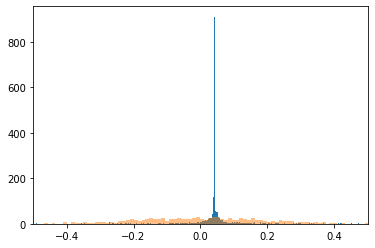

In [40]:
lower, median, upper, samples = model.predict_credible_layer(
    obs_noise=True,
    sample_size=1000,
    num_latent_samples=50,
    num_gp_samples=51
)
print(samples.shape)
mean = np.mean(samples, axis=0)[5, :, 0]
plt.hist(Y, bins=10000)
plt.hist(mean, bins=100, alpha=0.5)
plt.xlim(-0.5,0.5)
# plt.scatter(X[:, 0], Y[:, 0], c='r')
# plt.plot(obs_new, median, c='b', alpha=0.2)
# plt.scatter(obs_new[:, 0], samples[0, 0], alpha=0.5)
# plt.fill_between(obs_new[:, 0], upper[:, 0], lower[:, 0], alpha=0.5)
plt.show()
plt.close()

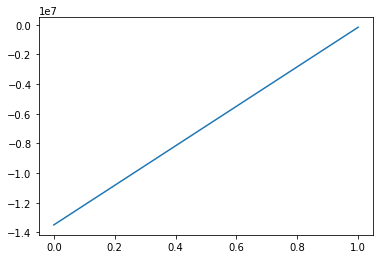

In [ ]:
plt.plot(np.arange(len(logf)), logf)
plt.show()

In [21]:
Y.std()

1.0

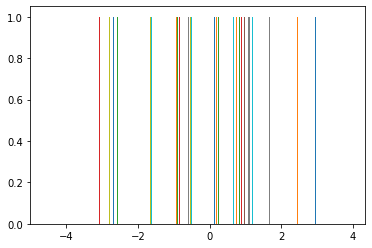

In [15]:

Xnew = tfp.distributions.Normal(loc=0, scale=1).sample([2000, 1])
Xnew = tf.cast(Xnew, dtype=default_float())
# Xnew = np.linspace(-2, 2, 1000)[:, None]
pred_f_mean, pred_f_var = model.predict_y(
    Xnew=Xnew)
plt.hist(pred_f_mean, bins=10)
# plt.scatter(Xnew, pred_f_mean, c='b', alpha=0.2)
# plt.scatter(inducing_in, np.zeros(100) )
# plt.fill_between(Xnew[:, 0], (pred_f_mean + 2 * np.sqrt(pred_f_var))[:, 0], (pred_f_mean - 2 * np.sqrt(pred_f_var))[:,0], alpha=0.5)
plt.show()
plt.close()


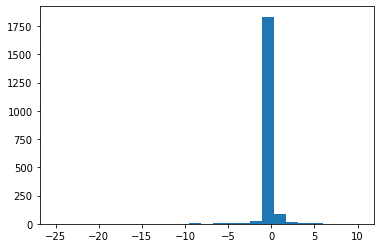

In [16]:
plt.hist(Y, bins=25)
plt.show()

In [9]:
obs_new = np.linspace(-5, 5, 1000)[:, None]

Xnew = tfp.distributions.Normal(loc=0, scale=1).sample([obs_new.shape[0], 1])
Xnew = tf.cast(Xnew, dtype=default_float())
Xnew = tf.concat(
    [obs_new, Xnew], axis=1
)
pred_f_mean, pred_f_var = model.predict_y(
    Xnew=Xnew,
)
plt.scatter(X[:, 0], Y[:, 0], c='r')
plt.plot(obs_new, pred_f_mean, c='b', alpha=0.2)
# plt.scatter(inducing_in, np.zeros(100) )
plt.fill_between(obs_new[:, 0], (pred_f_mean + 2 * np.sqrt(pred_f_var))[:, 0], (pred_f_mean - 2 * np.sqrt(pred_f_var))[:,0], alpha=0.5)
plt.show()
plt.close()


InvalidArgumentError: Matrix size-incompatible: In[0]: [200,1], In[1]: [2,1000] [Op:MatMul]

In [ ]:
M = 200  # Number of inducing locations

kernel_1 = gpflow.kernels.SquaredExponential(
    lengthscales=[0.003]
    # lengthscales=[lengthscales[0], lengthscales[1]]
)
# kernel_1.variance.assign(kernl_var)
kernel_2 = gpflow.kernels.Linear()
kernel = gpflow.kernels.Sum([kernel_1, kernel_2])
Z = np.linspace(X.min(), X.max(), M).reshape(-1, 1)
model =  gpflow.models.SVGP(
    kernel, gpflow.likelihoods.Gaussian(variance=1e-5), Z, num_data=N)


In [ ]:
minibatch_size = 100

train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)).repeat().shuffle(N)


In [ ]:
def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    gpflow.set_trainable(model.q_mu, False)
    gpflow.set_trainable(model.q_sqrt, False)
    variational_params = [(model.q_mu, model.q_sqrt)]
    natgrad_opt = NaturalGradient(gamma=0.1)
    optimizer = tf.optimizers.Adam(0.005)
    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)
        natgrad_opt.minimize(training_loss, variational_params)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf

In [ ]:
_ = run_adam(
    model, 
    iterations=30000
)

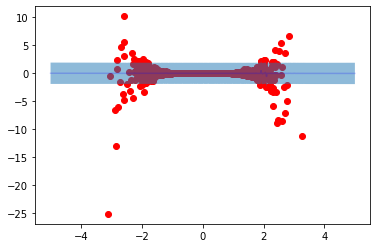

In [ ]:
obs_new = np.linspace(-5, 5, 1000)[:, None]

Xnew = obs_new
pred_f_mean, pred_f_var = model.predict_y(
    Xnew=Xnew,
)
plt.scatter(X[:, 0], Y[:, 0], c='r')
plt.plot(obs_new, pred_f_mean, c='b', alpha=0.2)
# plt.scatter(inducing_in, np.zeros(100) )
plt.fill_between(obs_new[:, 0], (pred_f_mean + 2 * np.sqrt(pred_f_var))[:, 0], (pred_f_mean - 2 * np.sqrt(pred_f_var))[:,0], alpha=0.5)
plt.show()
plt.close()